# Imports

In [1]:
# %matplotlib qt5

import numpy as np
import matplotlib.pyplot as plt
from mathphys.functions import load, save
from pycolleff.longitudinal_equilibrium import (
    ImpedanceSource,
    LongitudinalEquilibrium,
)

from pycolleff.rings import maxiv, als, half, sirius

from pycolleff.longitudinal_equilibrium import _mytrapz

from pycolleff.colleff import Ring

import matplotlib as mplt
import matplotlib.cm as cmap

import scienceplots
from itertools import product

mplt.style.use("science")

plt.rcParams.update(
    {
        "font.size": 18,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.5,
    }
)

plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.right"] = False
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.top"] = False

c = 299_792_458

# Methods

In [2]:
def calc_equilibrium_for_fixed_detuning(
    ring, hcav, current, detune, longeq=None
):
    """Calculate the equilibrium for a fixed cavity and current."""
    h = ring.harm_num
    ring.total_current = current
    fill = np.ones(h) / h

    if longeq is None:
        longeq = LongitudinalEquilibrium(
            ring=ring,
            impedance_sources=[
                hcav,
            ],
            fillpattern=fill,
        )
        longeq.feedback_on = False
        longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb / 2
        # longeq.zgrid = np.linspace(-0.9, 0.9, 2001) * ring.rf_lamb/2
    else:
        longeq.ring = ring
        longeq.impedance_sources = [hcav]
        longeq.ring.total_current = current
        longeq.fillpattern = fill

    longeq.impedance_sources[0].detune_w = 2 * np.pi * detune
    _ = longeq.calc_longitudinal_equilibrium(
        niter=1_000, tol=1e-8, beta=0.1, print_flag=True, m=3
    )
    return longeq


def calc_equilibrium_for_flat_potential(
    ring, hcav, current, nr_iters=7, longeq=None
):
    """Calculate equilibrium to flat potential condition.

    This method will change the detune_angle of the cavity so that
    the beam induced voltage amplitude matches the flat potential
    condition.

    It will iterate a few times so that the form factor of the
    distribution converges.
    """
    h = ring.harm_num
    fill = np.ones(h) / h
    ring.total_current = current

    if longeq is None:
        longeq = LongitudinalEquilibrium(
            ring=ring,
            impedance_sources=[
                hcav,
            ],
            fillpattern=fill,
        )
        longeq.feedback_on = False
        longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb / 2
        # longeq.zgrid = np.linspace(-0.9, 0.9, 2001) * ring.rf_lamb/2
    else:
        longeq.ring = ring
        longeq.impedance_sources = [hcav]
        longeq.ring.total_current = current
        longeq.fillpattern = fill

    for _ in range(nr_iters):
        kharm = longeq.calc_harmonic_voltage_for_flat_potential()
        vharm = kharm * longeq.ring.gap_voltage
        angle = longeq.calc_detune_for_fixed_harmonic_voltage(
            vharm, Rs=hcav.shunt_impedance
        )
        hcav.detune_angle = angle
        longeq.impedance_sources[0] = hcav
        print(f"detune: {hcav.detune_w/2/np.pi/1e3:.3f} kHz")

        _ = longeq.calc_longitudinal_equilibrium(
            niter=1000, tol=1e-8, beta=0.1, print_flag=False, m=3
        )
    return longeq


###############################################################################
def calc_lmci(
    longeq,
    cbmode=1,
    max_azi=2,
    max_rad=1,
    use_fokker=True,
    delete_m0=False,
    delete_m0k0=True,
    reduced=False,
):
    """Calculate LMCI for a given coupled bunch mode and equilibrium condition.

    Args:
        longeq: object from Longitudinal equilibrium class;
        cbmode: coupled-bunch mode to evaluate must be in range [0, h-1].
            Defaults to 1, which is the mode of PTBL instability;
        max_azi: maximum azimuthal mode to consider in expansion.
            Detaults to 2. Found to be enough to explain PTBL instability;
        max_azi: maximum radial mode to consider in expansion. Defaults to 1.
            Also found to be enough to explain PTBL instability.

    Returns:
        eigenfreq: complex coherent eigen angular frequencies in [rad/s];
        freqshift: frequency of the most unstable mode in [Hz];
        grate: growth rate of the most unstable mode in [1/s];
        sync_freq: incoherent synchrotron frequency used in calculations [Hz];
        peak_hvolt: peak voltage of harmonic cavity [V].

    """
    hcav = longeq.impedance_sources[0]
    hvolt = longeq.calc_induced_voltage_wake(
        dist=longeq.distributions, wake_source=hcav
    )
    mvolt = longeq.main_voltage
    tvolt = mvolt + hvolt
    peak_hvolt = np.max(np.abs(hvolt[0, :]))
    peak_mvolt = np.max(np.abs(mvolt))

    print(f"current: {longeq.ring.total_current*1e3:.2f} mA")
    print(f"detune: {hcav.detune_w/2/np.pi/1e3:.3f} kHz")
    print(f"detune angle: {np.rad2deg(hcav.detune_angle):.1f} deg")
    print(f"R/Q: {hcav.shunt_impedance/hcav.Q:.1f} Ohm")
    print(f"HC voltage: {peak_hvolt/1e3:.1f} kV")
    ratio = peak_hvolt / peak_mvolt
    print(f"HC voltage ratio: {ratio:.3f}")

    wrf = longeq.ring.rf_ang_freq
    dist, pot = longeq.calc_distributions_from_voltage(longeq.total_voltage)
    z0, sigmaz = longeq.calc_moments(longeq.zgrid, dist[0])
    sigmaz = sigmaz[0]

    # Calculate the equivalent synchrotron frequency:
    # Equivalent single-rf (quadratic) potential.
    # Sync. frequency determined by bunch length
    sync_freq = longeq.ring.espread * longeq.ring.mom_comp * c
    sync_freq /= sigmaz * 2 * np.pi
    print(f"FREQ BY BUNCH LENGTH: {sync_freq:.5f} Hz")

#     Sync. freq. by voltage derivative average by distribution
#     sync_data = longeq.calc_synchrotron_frequency(
#         method='derivative', nrpts=500, max_amp=5)
#     sync_freq = sync_data['avg_sync_freq']
#     print(f"FREQ BY V'(z): {sync_freq:.5f} Hz")

#     # Amplitude-dependent Sync. freq. averaged by action distribution
#     sync_data = longeq.calc_synchrotron_frequency(
#         method='action', nrpts=500, max_amp=5)
#     sync_freq = sync_data['avg_sync_freq']
#     print(f"FREQ BY w(J): {sync_freq:.5f} Hz")

    longeq.ring.sync_tune = sync_freq / longeq.ring.rev_freq
    longeq.ring.bunlen = sigmaz

    print(
        f"sync. freq.: {longeq.ring.sync_tune * longeq.ring.rev_freq:.3f} Hz"
    )
    print(f"bunch length: {longeq.ring.bunlen*1e3:.3f} mm")

    # Calculate Vlasov's equation eigen-frequencies:
    wrf = longeq.ring.rf_ang_freq
    eigenfreq, *_ = longeq.calc_mode_coupling(
        w=[-10 * wrf, +10 * wrf],
        cbmode=cbmode,
        max_azi=max_azi,
        max_rad=max_rad,
        use_fokker=use_fokker,
        delete_m0=delete_m0,
        delete_m0k0=delete_m0k0,
        reduced=reduced,
    )

    # Find most unstable mode:
    idx = np.argmax(eigenfreq.imag)
    freqshift = eigenfreq.real[idx] / 2 / np.pi
    grate = eigenfreq.imag[idx]
    if reduced:
        # Subtract radiation damping rate from "reduced" simulation:
        grate -= 1 / longeq.ring.dampte

    print("Most unstable mode:")
    print(f"    frequency: {freqshift:.2f} Hz")
    print(f"    growth rate: {grate:.2f} 1/s")
    print("\n")
    return eigenfreq, freqshift, grate, sync_freq, peak_hvolt


def calc_lmci_scan_current(
    ring,
    hcav,
    current_scan,
    max_azi=3,
    max_rad=2,
    use_fokker=True,
    delete_m0=False,
    delete_m0k0=True,
    reduced=False,
    stop_when_unstable=False,
):
    """Calculate equilibrium and solve Vlasov equation for a current set.

    The cavity will be detuned to flat potential condition at each current.

    """
    growths, shifts, syncdata, peak_hvolts, eigenfreqs = [], [], [], [], []
    longeq = None
    cbmode = 1
    # cbpmode = ring.harm_num-1
    for i, current in enumerate(current_scan):
        longeq = calc_equilibrium_for_flat_potential(
            ring,
            hcav,
            current=current,
            nr_iters=8,
            longeq=longeq,
        )
        eigenfreq, tuneshift, grate, sync_freq, peak_hvolt = calc_lmci(
            longeq,
            cbmode=cbmode,
            max_azi=max_azi,
            max_rad=max_rad,
            use_fokker=use_fokker,
            delete_m0=delete_m0,
            delete_m0k0=delete_m0k0,
            reduced=reduced,
        )
        growths.append(grate)
        shifts.append(tuneshift)
        syncdata.append(sync_freq)
        peak_hvolts.append(peak_hvolt)
        eigenfreqs.append(eigenfreq)
        
        if stop_when_unstable and grate > 0:
            break
    growths = np.array(growths)
    shifts = np.array(shifts)
    syncdata = np.array(syncdata)
    peak_hvolts = np.array(peak_hvolts)
    eigenfreqs = np.array(eigenfreqs)
    return growths, shifts, syncdata, peak_hvolts, eigenfreqs


def calc_lmci_scan_detuning(
    ring,
    hcav,
    current,
    detuning_scan,
    max_azi=3,
    max_rad=2,
    use_fokker=True,
    delete_m0=False,
    delete_m0k0=True,
    reduced=False,
    stop_when_unstable=False,
):
    """Calculate equilibrium and solve Vlasov equation for a detuning set."""
    growths, shifts, syncdata, peak_hvolts = [], [], [], []
    longeq = None
    cbmode = 1
    # cbpmode = ring.harm_num-1
    for i, detune in enumerate(detuning_scan):
        longeq = calc_equilibrium_for_fixed_detuning(
            ring,
            hcav,
            current,
            detune=detune,
            longeq=longeq,
        )
        eigenfreq, tuneshift, grate, sync_freq, peak_hvolt = calc_lmci(
            longeq,
            cbmode=cbmode,
            max_azi=max_azi,
            max_rad=max_rad,
            use_fokker=use_fokker,
            delete_m0=delete_m0,
            delete_m0k0=delete_m0k0,
            reduced=reduced,
        )
        growths.append(grate)
        shifts.append(tuneshift)
        syncdata.append(sync_freq)
        peak_hvolts.append(peak_hvolt)
        
        if stop_when_unstable and grate > 0:
            break
    growths = np.array(growths)
    shifts = np.array(shifts)
    syncdata = np.array(syncdata)
    peak_hvolts = np.array(peak_hvolts)
    return growths, shifts, syncdata, peak_hvolts, eigenfreq

# MAX-IV

In [3]:
ring = maxiv.create_ring(energy=3)
# ring.gap_voltage = 1.397e6

ring.gap_voltage = 1.0e6
ring.total_current = 300e-3
print(ring)

Lattice Version             :     MAX-IV-3GeV     
Circumference [m]           :       527.999       
Revolution Period [us]      :        1.761        
Revolution Frequency [kHz]  :       567.790       
Energy [GeV]                :        3.000        
U0 [keV]                    :       363.800       
Vgap [MV]                   :        1.000        
Momentum Compaction         :       3.06e-04      
Harmonic Number             :         176         
Current [mA]                :       300.000       
Current per Bunch [mA]      :        1.705        
Synchrotron Tune            :       0.00164       
Tunes x/y                   :    16.280/42.200    
Chromaticities x/y          :     1.000/1.000     
Damping Times x/y/e [ms]    :   15.7/ 29.0 /25.2  
Energy Spread [%]           :        0.0769       
Bunch Length [mm]           :        10.694       



In [4]:
hcav = ImpedanceSource()
hcav.harm_rf = 3
hcav.Q = 20_800
# ncavs = 3

# simulating 2 harmonic cavities
ncavs = 2
hcav.shunt_impedance = 2.75e6 * ncavs

twopi = 2 * np.pi
hcav.ang_freq_rf = twopi * ring.rf_freq
hcav.ang_freq = hcav.harm_rf * hcav.ang_freq_rf

hcav.detune_w = twopi * 85e3
hcav.calc_method = ImpedanceSource.Methods.ImpedanceDFT
hcav.active_passive = ImpedanceSource.ActivePassive.Passive

In [5]:
current_scan = np.linspace(50, 500, 20) * 1e-3
grate, freq, sync_freq, peak_hvolt, eigs = calc_lmci_scan_current(
    ring,
    hcav,
    current_scan,
    max_azi=2,
    max_rad=1,
    use_fokker=True,
    delete_m0=True,
    delete_m0k0=True,
    reduced=False,
    stop_when_unstable=False,
)

detune: 10.641 kHz
detune: 10.276 kHz
detune: 10.211 kHz
detune: 10.197 kHz
detune: 10.194 kHz
detune: 10.193 kHz
detune: 10.193 kHz
detune: 10.193 kHz
current: 50.00 mA
detune: 10.193 kHz
detune angle: 54.7 deg
R/Q: 264.4 Ohm
HC voltage: 307.6 kV
HC voltage ratio: 0.308
FREQ BY BUNCH LENGTH: 278.09628 Hz
sync. freq.: 278.096 Hz
bunch length: 40.373 mm
Most unstable mode:
    frequency: 276.41 Hz
    growth rate: -39.59 1/s


detune: 16.926 kHz
detune: 16.650 kHz
detune: 16.552 kHz
detune: 16.514 kHz
detune: 16.499 kHz
detune: 16.493 kHz
detune: 16.491 kHz
detune: 16.490 kHz
current: 73.68 mA
detune: 16.490 kHz
detune angle: 66.4 deg
R/Q: 264.4 Ohm
HC voltage: 307.6 kV
HC voltage ratio: 0.308
FREQ BY BUNCH LENGTH: 214.75646 Hz
sync. freq.: 214.756 Hz
bunch length: 52.281 mm
Most unstable mode:
    frequency: 210.37 Hz
    growth rate: -39.40 1/s


detune: 22.662 kHz
detune: 22.546 kHz
detune: 22.496 kHz
detune: 22.474 kHz
detune: 22.464 kHz
detune: 22.460 kHz
detune: 22.458 kHz
detune:

detune: 120.705 kHz
detune: 120.713 kHz
detune: 120.717 kHz
detune: 120.719 kHz
detune: 120.720 kHz
detune: 120.720 kHz
detune: 120.720 kHz
current: 500.00 mA
detune: 120.720 kHz
detune angle: 86.6 deg
R/Q: 264.4 Ohm
HC voltage: 307.6 kV
HC voltage ratio: 0.308
FREQ BY BUNCH LENGTH: 198.05168 Hz
sync. freq.: 198.052 Hz
bunch length: 56.690 mm
Most unstable mode:
    frequency: 4.63 Hz
    growth rate: 955.93 1/s




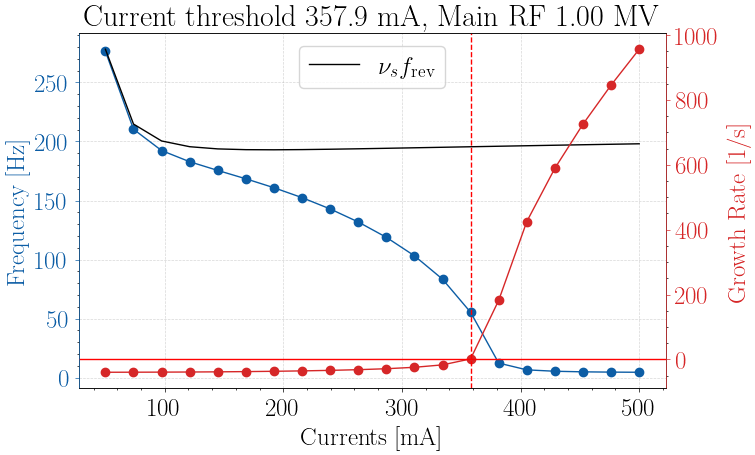

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ay = ax.twinx()
ax.plot(current_scan * 1e3, freq, "o-")
ax.plot(current_scan * 1e3, sync_freq, color="k", label=r"$\nu_sf_\text{rev}$")
ay.plot(current_scan * 1e3, np.array(grate), "o-", color="tab:red")
thre = current_scan[np.argmax(grate > 0)] * 1e3
ay.axhline(0, ls='-', color='r')
ay.axvline(thre, ls='--', color='r')
ay.set_title(f"Current threshold {thre:.1f} mA, Main RF {ring.gap_voltage/1e6:.2f} MV")

ay.grid(False)
ay.spines["right"].set_color("tab:red")
# plt.setp(ay.yaxis.get_ticklabels(), color='tab:red')
ay.tick_params(axis="y", colors="tab:red")

ay.spines["left"].set_color("C0")
plt.setp(ax.yaxis.get_ticklabels(), color="tab:red")
ax.tick_params(axis="y", colors="C0")

ax.legend(loc="upper center", frameon=True)
# ay.legend(loc="center left", frameon=True)
ax.set_ylabel("Frequency [Hz]", color="C0")
ax.set_xlabel("Currents [mA]")
ay.set_ylabel("Growth Rate [1/s]", color="tab:red")
fig.tight_layout()
plt.show()

In [8]:
current_scan = np.linspace(300, 400, 31) * 1e-3
main_rf = np.linspace(900, 1100, 11) * 1e3
thresholds = []

for rf in main_rf:
    ring.gap_voltage = rf
    grate, freq, sync_freq, peak_hvolt, eigs = calc_lmci_scan_current(
        ring,
        hcav,
        current_scan,
        max_azi=2,
        max_rad=1,
        use_fokker=True,
        delete_m0=True,
        delete_m0k0=True,
        reduced=False,
        stop_when_unstable=True,
    )
    idx_unstable = np.argmax(grate > 0)
    thre = current_scan[idx_unstable] * 1e3
    current_scan = current_scan[idx_unstable:]
    print(rf/1000, thre)
    thresholds.append(thre)
    
thresholds = np.array(thresholds)

detune: 87.174 kHz
detune: 83.662 kHz
detune: 82.449 kHz
detune: 81.934 kHz
detune: 81.700 kHz
detune: 81.590 kHz
detune: 81.539 kHz
detune: 81.514 kHz
current: 300.00 mA
detune: 81.514 kHz
detune angle: 84.9 deg
R/Q: 264.4 Ohm
HC voltage: 271.1 kV
HC voltage ratio: 0.301
FREQ BY BUNCH LENGTH: 189.26545 Hz
sync. freq.: 189.265 Hz
bunch length: 59.322 mm
Most unstable mode:
    frequency: 88.15 Hz
    growth rate: -20.46 1/s


detune: 82.415 kHz
detune: 82.412 kHz
detune: 82.410 kHz
detune: 82.410 kHz
detune: 82.409 kHz
detune: 82.409 kHz
detune: 82.409 kHz
detune: 82.409 kHz
current: 303.33 mA
detune: 82.409 kHz
detune angle: 85.0 deg
R/Q: 264.4 Ohm
HC voltage: 271.1 kV
HC voltage ratio: 0.301
FREQ BY BUNCH LENGTH: 189.16379 Hz
sync. freq.: 189.164 Hz
bunch length: 59.354 mm
Most unstable mode:
    frequency: 84.53 Hz
    growth rate: -19.05 1/s


detune: 83.321 kHz
detune: 83.324 kHz
detune: 83.325 kHz
detune: 83.326 kHz
detune: 83.326 kHz
detune: 83.326 kHz
detune: 83.326 kHz
detune:

detune: 86.177 kHz
detune: 86.175 kHz
detune: 86.175 kHz
detune: 86.174 kHz
detune: 86.174 kHz
detune: 86.174 kHz
detune: 86.174 kHz
current: 350.00 mA
detune: 86.174 kHz
detune angle: 85.2 deg
R/Q: 264.4 Ohm
HC voltage: 300.4 kV
HC voltage ratio: 0.306
FREQ BY BUNCH LENGTH: 194.37403 Hz
sync. freq.: 194.374 Hz
bunch length: 57.763 mm
Most unstable mode:
    frequency: 58.26 Hz
    growth rate: -1.53 1/s


detune: 87.000 kHz
detune: 87.002 kHz
detune: 87.003 kHz
detune: 87.004 kHz
detune: 87.004 kHz
detune: 87.004 kHz
detune: 87.004 kHz
detune: 87.004 kHz
current: 353.33 mA
detune: 87.004 kHz
detune angle: 85.3 deg
R/Q: 264.4 Ohm
HC voltage: 300.4 kV
HC voltage ratio: 0.306
FREQ BY BUNCH LENGTH: 194.43653 Hz
sync. freq.: 194.437 Hz
bunch length: 57.745 mm
Most unstable mode:
    frequency: 53.23 Hz
    growth rate: 3.19 1/s


980.0 353.3333333333333
detune: 90.546 kHz
detune: 87.110 kHz
detune: 85.927 kHz
detune: 85.426 kHz
detune: 85.200 kHz
detune: 85.095 kHz
detune: 85.046 kHz
detun

In [9]:
# From PRAB paper https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.27.044403

maxiv_data_curr = [399, 394, 390, 385, 380, 375, 370, 365, 360]
maxiv_data_main_rf = [1070, 1050, 1035, 1020, 1010, 995, 985, 965, 945]

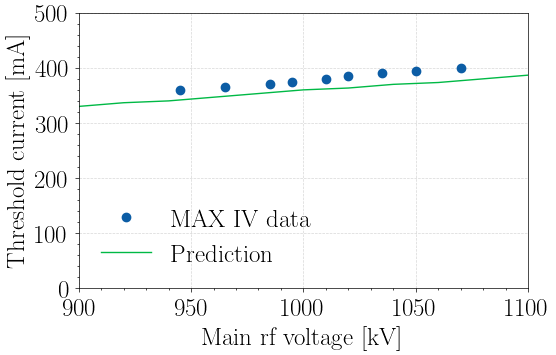

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(maxiv_data_main_rf, maxiv_data_curr, 'o', label='MAX IV data')
plt.plot(main_rf/1e3, thresholds, label='Prediction')
plt.legend()
# use the same y-scale of Fig. 11 from the paper.
plt.ylim([0, 500])
plt.xlim([900, 1100])
plt.xlabel('Main rf voltage [kV]')
plt.ylabel('Threshold current [mA]')
plt.tight_layout()
plt.show()

In [11]:
current = 360e-3
detune_scan = np.linspace(150, 80, 31) * 1e3
ring.gap_voltage = 1.0e6

grate, freq, sync_freq, peak_hvolt, eigs = calc_lmci_scan_detuning(
    ring,
    hcav,
    current,
    detune_scan,
    max_azi=2,
    max_rad=1,
    use_fokker=True,
    delete_m0=True,
    delete_m0k0=True,
    reduced=False,
    stop_when_unstable=False,
)

Iter.: 001, Dist. Diff.: 1.545e-01 (bucket 000), E.T.: 0.052s
--------------------
Iter.: 002, Dist. Diff.: 1.177e-01 (bucket 000), E.T.: 0.052s
--------------------
Iter.: 003, Dist. Diff.: 2.625e-02 (bucket 000), E.T.: 0.047s
--------------------
Iter.: 004, Dist. Diff.: 1.945e-02 (bucket 000), E.T.: 0.054s
--------------------
Iter.: 005, Dist. Diff.: 1.892e-03 (bucket 001), E.T.: 0.085s
--------------------
Iter.: 006, Dist. Diff.: 1.155e-05 (bucket 013), E.T.: 0.083s
--------------------
Iter.: 007, Dist. Diff.: 1.015e-05 (bucket 013), E.T.: 0.061s
--------------------
Iter.: 008, Dist. Diff.: 3.149e-07 (bucket 013), E.T.: 0.076s
--------------------
Iter.: 009, Dist. Diff.: 2.809e-07 (bucket 013), E.T.: 0.087s
--------------------
Iter.: 010, Dist. Diff.: 7.479e-08 (bucket 001), E.T.: 0.074s
--------------------
Iter.: 011, Dist. Diff.: 3.312e-08 (bucket 001), E.T.: 0.064s
--------------------
Iter.: 012, Dist. Diff.: 2.926e-08 (bucket 001), E.T.: 0.111s
--------------------
Iter

Iter.: 001, Dist. Diff.: 1.401e-02 (bucket 015), E.T.: 0.064s
--------------------
Iter.: 002, Dist. Diff.: 5.068e-03 (bucket 007), E.T.: 0.083s
--------------------
Iter.: 003, Dist. Diff.: 5.601e-04 (bucket 003), E.T.: 0.065s
--------------------
Iter.: 004, Dist. Diff.: 2.075e-04 (bucket 006), E.T.: 0.068s
--------------------
Iter.: 005, Dist. Diff.: 8.817e-09 (bucket 006), E.T.: 0.070s
--------------------
distribution ok!
current: 360.00 mA
detune: 124.333 kHz
detune angle: 86.7 deg
R/Q: 264.4 Ohm
HC voltage: 226.9 kV
HC voltage ratio: 0.227
FREQ BY BUNCH LENGTH: 486.13799 Hz
sync. freq.: 486.138 Hz
bunch length: 23.096 mm
Most unstable mode:
    frequency: 447.42 Hz
    growth rate: -33.73 1/s


Iter.: 001, Dist. Diff.: 1.553e-02 (bucket 012), E.T.: 0.080s
--------------------
Iter.: 002, Dist. Diff.: 6.177e-03 (bucket 012), E.T.: 0.070s
--------------------
Iter.: 003, Dist. Diff.: 4.935e-04 (bucket 013), E.T.: 0.074s
--------------------
Iter.: 004, Dist. Diff.: 2.024e-04 (buc

Iter.: 006, Dist. Diff.: 2.580e-06 (bucket 006), E.T.: 0.063s
--------------------
Iter.: 007, Dist. Diff.: 2.234e-06 (bucket 006), E.T.: 0.052s
--------------------
Iter.: 008, Dist. Diff.: 1.251e-08 (bucket 013), E.T.: 0.071s
--------------------
Iter.: 009, Dist. Diff.: 4.404e-09 (bucket 013), E.T.: 0.056s
--------------------
distribution ok!
current: 360.00 mA
detune: 103.333 kHz
detune angle: 86.0 deg
R/Q: 264.4 Ohm
HC voltage: 270.1 kV
HC voltage ratio: 0.270
FREQ BY BUNCH LENGTH: 349.12231 Hz
sync. freq.: 349.122 Hz
bunch length: 32.160 mm
Most unstable mode:
    frequency: 301.53 Hz
    growth rate: -32.48 1/s


Iter.: 001, Dist. Diff.: 5.150e-02 (bucket 013), E.T.: 0.055s
--------------------
Iter.: 002, Dist. Diff.: 4.229e-02 (bucket 013), E.T.: 0.077s
--------------------
Iter.: 003, Dist. Diff.: 4.775e-03 (bucket 006), E.T.: 0.068s
--------------------
Iter.: 004, Dist. Diff.: 1.970e-03 (bucket 006), E.T.: 0.070s
--------------------
Iter.: 005, Dist. Diff.: 3.160e-05 (buc

Iter.: 019, Dist. Diff.: 6.060e-07 (bucket 009), E.T.: 0.059s
--------------------
Iter.: 020, Dist. Diff.: 4.593e-07 (bucket 009), E.T.: 0.062s
--------------------
Iter.: 021, Dist. Diff.: 3.307e-07 (bucket 007), E.T.: 0.090s
--------------------
Iter.: 022, Dist. Diff.: 1.571e-07 (bucket 008), E.T.: 0.073s
--------------------
Iter.: 023, Dist. Diff.: 1.387e-07 (bucket 015), E.T.: 0.070s
--------------------
Iter.: 024, Dist. Diff.: 3.133e-08 (bucket 005), E.T.: 0.046s
--------------------
Iter.: 025, Dist. Diff.: 2.408e-08 (bucket 005), E.T.: 0.062s
--------------------
Iter.: 026, Dist. Diff.: 1.563e-08 (bucket 013), E.T.: 0.058s
--------------------
Iter.: 027, Dist. Diff.: 1.329e-08 (bucket 008), E.T.: 0.067s
--------------------
Iter.: 028, Dist. Diff.: 1.042e-08 (bucket 005), E.T.: 0.077s
--------------------
Iter.: 029, Dist. Diff.: 9.690e-09 (bucket 005), E.T.: 0.067s
--------------------
distribution ok!
current: 360.00 mA
detune: 91.667 kHz
detune angle: 85.5 deg
R/Q: 264.

Iter.: 012, Dist. Diff.: 1.818e-03 (bucket 007), E.T.: 0.081s
--------------------
Iter.: 013, Dist. Diff.: 2.623e-03 (bucket 006), E.T.: 0.066s
--------------------
Iter.: 014, Dist. Diff.: 4.862e-04 (bucket 007), E.T.: 0.071s
--------------------
Iter.: 015, Dist. Diff.: 2.308e-04 (bucket 010), E.T.: 0.085s
--------------------
Iter.: 016, Dist. Diff.: 7.732e-05 (bucket 007), E.T.: 0.066s
--------------------
Iter.: 017, Dist. Diff.: 2.506e-05 (bucket 003), E.T.: 0.119s
--------------------
Iter.: 018, Dist. Diff.: 1.765e-06 (bucket 004), E.T.: 0.125s
--------------------
Iter.: 019, Dist. Diff.: 9.956e-07 (bucket 005), E.T.: 0.086s
--------------------
Iter.: 020, Dist. Diff.: 7.203e-07 (bucket 009), E.T.: 0.061s
--------------------
Iter.: 021, Dist. Diff.: 6.296e-07 (bucket 011), E.T.: 0.063s
--------------------
Iter.: 022, Dist. Diff.: 1.760e-07 (bucket 000), E.T.: 0.069s
--------------------
Iter.: 023, Dist. Diff.: 1.464e-07 (bucket 011), E.T.: 0.063s
--------------------
Iter

Iter.: 030, Dist. Diff.: 2.101e-05 (bucket 014), E.T.: 0.057s
--------------------
Iter.: 031, Dist. Diff.: 1.685e-05 (bucket 005), E.T.: 0.064s
--------------------
Iter.: 032, Dist. Diff.: 1.619e-05 (bucket 005), E.T.: 0.055s
--------------------
Iter.: 033, Dist. Diff.: 8.978e-06 (bucket 005), E.T.: 0.060s
--------------------
Iter.: 034, Dist. Diff.: 6.203e-06 (bucket 005), E.T.: 0.062s
--------------------
Iter.: 035, Dist. Diff.: 2.737e-06 (bucket 002), E.T.: 0.062s
--------------------
Iter.: 036, Dist. Diff.: 2.249e-06 (bucket 002), E.T.: 0.059s
--------------------
Iter.: 037, Dist. Diff.: 2.554e-06 (bucket 002), E.T.: 0.051s
--------------------
Iter.: 038, Dist. Diff.: 1.402e-06 (bucket 003), E.T.: 0.053s
--------------------
Iter.: 039, Dist. Diff.: 1.098e-06 (bucket 014), E.T.: 0.084s
--------------------
Iter.: 040, Dist. Diff.: 1.207e-06 (bucket 001), E.T.: 0.059s
--------------------
Iter.: 041, Dist. Diff.: 5.860e-07 (bucket 003), E.T.: 0.065s
--------------------
Iter

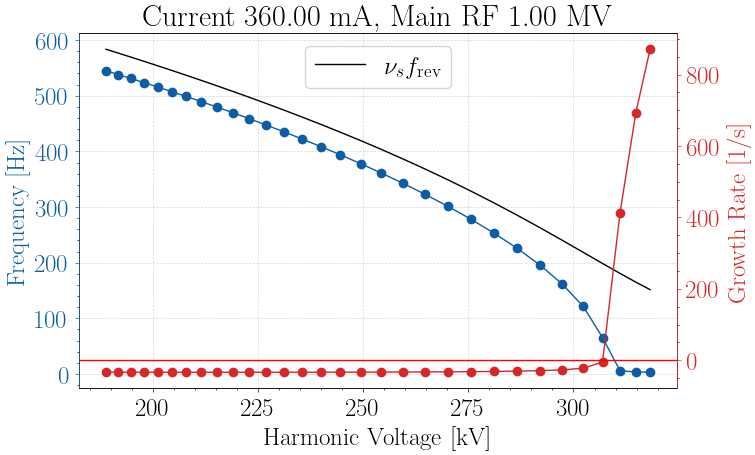

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ay = ax.twinx()

norm = 1
ax.plot(peak_hvolt * 1e-3 / norm, freq, "o-")
ax.plot(peak_hvolt * 1e-3 / norm, sync_freq, color="k", label=r"$\nu_sf_{\text{rev}}$")
ay.plot(peak_hvolt * 1e-3 / norm, grate, "o-", color="tab:red")

ay.axhline(0, color='r')
ax.set_title(f"Current {current*1e3:.2f} mA, Main RF {ring.gap_voltage/1e6:.2f} MV")
# ax.axvline(448.181)

ay.grid(False)
ay.spines["right"].set_color("tab:red")
# plt.setp(ay.yaxis.get_ticklabels(), color='tab:red')
ay.tick_params(axis="y", colors="tab:red")

ay.spines["left"].set_color("C0")
plt.setp(ax.yaxis.get_ticklabels(), color="tab:red")
ax.tick_params(axis="y", colors="C0")

ax.legend(loc="upper center", frameon=True)
ax.set_ylabel("Frequency [Hz]", color="C0")
ax.set_xlabel("Harmonic Voltage [kV]")
ay.set_ylabel("Growth Rate [1/s]", color="tab:red")
fig.tight_layout()
plt.show()